# Multi layer RNN (many to one)

In [1]:
from tqdm import tqdm
import pandas as pd
import os

basepath = '/Users/sejongpyo/Downloads/aclImdb'

labels = {'pos':1, 'neg':0}
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 'r', encoding = 'utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index = True)
df.columns = ['review', 'sentiment']

In [2]:
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index = False, encoding = 'utf-8')

In [3]:
df = pd.read_csv("movie_data.csv", encoding = 'utf-8')
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [1]:
import re
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

RNN 신경망에 주입하기 위해 텍스트를 정수 값으로 인코딩

In [6]:
from collections import Counter

# split words and count occurance
counts = Counter()
for i, review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' for c in review]).lower()
    df.loc[i, 'review'] = text
    counts.update(text.split())
    
word_counts = sorted(counts, key = counts.get, reverse = True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []

for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])


['the', '.', ',', 'and', 'a']


시퀀스의 길이가 동일해야 한다. 따라서 정한 파라미터 값보다 적으면 왼쪽에 0 패딩, 길면 마지막 200개만 사용
1. 행 갤이가 시퀀스 크기에 해당하는 행렬을 만들고 0으로 채움
2. 행렬 오른쪽부터 시퀀스의 단어 인덱스로 채움

In [7]:
sequence_length = 200
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype = int)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

In [9]:
X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [10]:
n_words = len(word_to_int) + 1
print(n_words)

102967


### embedding
- 원핫 벡터의 경우, 특성의 수가 많을 경우 산출되는 차원이 기하급수적으로 커지기 때문에 차원의 저주에 빠질 위험이 있다.
- 실수 값을 가진 고정된 길이의 벡터로 변환한다. -> [-1, 1] 사이에서 무한한 실수로 뽑는다.
- 이를 사용하면 중요한 특성을 자동으로 학습할 수 있다. embedding_size << unique_words

In [11]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(n_words, 200, embeddings_regularizer = 'l2'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


출력 3차원 텐서 (batch, time stamp, embedding vector dimension)

두 개 이상의 순환층을 쌓는다면 아래층에서 만든 모든 스텝의 출력이 위층 입력으로 전달되어야 하는데 이때 return_sequences 매개변수를 True

In [12]:
model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = 'sentiment_rnn_checkpoint.h5',
                                 monitor = 'val_loss',
                                 save_best_only = True),
                 TensorBoard(log_dir = 'sentiment_rnn_logs/{}'.format(time.asctime()))]

history = model.fit(X_train, y_train, batch_size = 64, epochs = 5,
                    validation_split = 0.3, callbacks = callback_list)

Epoch 1/5
411/411 [==============================] - 113s 276ms/step - loss: 0.5597 - acc: 0.8397 - val_loss: 0.5294 - val_acc: 0.8637
Epoch 2/5
411/411 [==============================] - 111s 271ms/step - loss: 0.5203 - acc: 0.8627 - val_loss: 0.5082 - val_acc: 0.8628
Epoch 3/5
411/411 [==============================] - 113s 275ms/step - loss: 0.4932 - acc: 0.8729 - val_loss: 0.4859 - val_acc: 0.8670
Epoch 4/5
411/411 [==============================] - 112s 272ms/step - loss: 0.4739 - acc: 0.8790 - val_loss: 0.4843 - val_acc: 0.8695
Epoch 5/5
411/411 [==============================] - 111s 269ms/step - loss: 0.4621 - acc: 0.8866 - val_loss: 0.5529 - val_acc: 0.8368


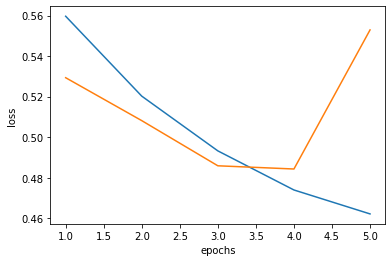

In [15]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 6)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

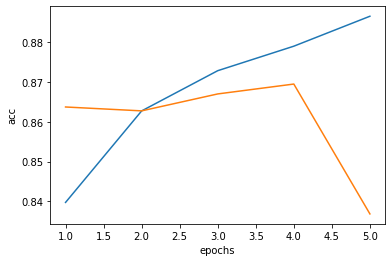

In [16]:
epochs = np.arange(1, 6)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

In [17]:
model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

391/391 [==============================] - 11s 28ms/step - loss: 0.4876 - acc: 0.8694


[0.4876074194908142, 0.8694400191307068]

In [21]:
model.predict_proba(X_test[:10])

array([[0.00670621],
       [0.00701451],
       [0.00208697],
       [0.97017026],
       [0.97045577],
       [0.98271126],
       [0.00607625],
       [0.9765721 ],
       [0.00382197],
       [0.8275779 ]], dtype=float32)

In [22]:
model.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

# 텐서플로로 글자 단위 언어 모델 구현
- goal : 입력 문서와 비슷한 새로운 텍스트를 생성하는 모델
- 글자 단위 언어 모델링에서 입력은 글자의 시퀀스로 나뉘어 한 번에 글자 하나씩 네트워크에 주입

각 글자와 정수를 매핑한 딕셔너리, 거꾸로 정수와 글자를 매핑한 딕셔너리를 만든다.

In [2]:
with open('pg2265.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()
    
text = text[15858:]
chars = set(text)
char2int = {ch:i for i, ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], dtype = np.int32)
print(len(text), len(chars))

163239 68


text_ints를 시퀀스의 배치로 바꾸는 작업 실시
1. 시퀀스 x와 y를 생성 : text_ints를 x, y에 동일하게 할당
2. x 다음으로 y가 들어가기 때문에 y를 한칸씩 땡기고 마지막에 0을 넣는다.

In [8]:
def reshape_data(sequence, batch_size, num_steps):
    mini_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / mini_batch_length)
    if num_batches * mini_batch_length + 1 > len(sequence):
        num_batches -= 1
    # 전체 배치에 포함되지 않는 시퀀스 끝부분 삭제
    x = sequence[0: num_batches * mini_batch_length]
    y = sequence[1: num_batches * mini_batch_length + 1]
    
    # x와 y를 시퀀스 배치의 리스트로 나눔
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

In [9]:
# 테스트
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :10]))
print(''.join(int2char[i] for i in train_y[0, :10]))

(64, 2550)
[32 29 26 47  1 26 20 47 28 29]
[29 26 47  1 26 20 47 28 29 26]
te of more
e of more 


In [11]:
def create_batch_generator(data_x, data_y, num_steps):
    '''배열 x와 y를 나누어 열 길이가 스텝 횟수와 동일한 미니 배치 생성
       메모리 부족을 해결하기 위해 제너레이터를 사용하는데 네트워크를
       훈련하는 동안 미니배치 반복한다.
    '''
    
    batch_size, tot_batch_length = data_x.shape[0:2]
    num_batches = int(tot_batch_length / num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps],
               data_y[:, b*num_steps: (b+1)*num_steps])

In [12]:
bgen = create_batch_generator(train_x[:, :100], train_y[:, :100], 15)
for x, y in bgen:
    print(x.shape, y.shape, end = ' ')
    print(''.join(int2char[i] for i in x[0, :]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in y[0, :]).replace('\n', '*'))

(64, 15) (64, 15) te of more than      e of more than 
(64, 15) (64, 15)  30 different*F      30 different*Fi
(64, 15) (64, 15) irst Folio edit      rst Folio editi
(64, 15) (64, 15) ions' best page      ons' best pages
(64, 15) (64, 15) s.**If you find      .**If you find 
(64, 15) (64, 15)  any scanning e      any scanning er


In [13]:
batch_size = 64
num_steps = 100
train_x, train_y = reshape_data(text_ints, batch_size, num_steps)
print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


In [14]:
from tensorflow.keras.utils import to_categorical

train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)
print(train_encoded_x.shape, train_encoded_y.shape)

(64, 2500, 68) (64, 2500, 68)


In [15]:
print(np.max(train_x), np.max(train_y))

67 67


In [16]:
'''
훈련할 때 길이가 100인 시퀀스를 주입 -> time step length = 100
새로운 글자 생성 시 (샘플링) 배치 크기 1

샘플링 : 배치 1, num_steps = 1
train : batch 64, num_steps = 100
'''

from tensorflow.keras import models, layers

num_classes = len(chars)

char_model = models.Sequential()
char_model.add(layers.LSTM(128, input_shape = (None, num_classes),
                           return_sequences = True))

# 모든 타임스텝에 대한 loss 계산을 위해 LSTM에서 출력되는 3차원 크기의 (배치개수, 타임스텝개수, 순환유닛개수)가 유지
char_model.add(layers.TimeDistributed(layers.Dense(num_classes, activation = 'softmax')))

char_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         100864    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 68)          8772      
Total params: 109,636
Trainable params: 109,636
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

adam = Adam(clipnorm = 5.0) # L2 norm threshold value
char_model.compile(loss = 'categorical_crossentropy', optimizer = adam)
callback_list = [ModelCheckpoint(filepath = 'char_rnn_checkpoint.h5')]

In [19]:
'''입력과 타깃 배치를 반환하는 fit_generator method 제공'''

for i in range(500):
    bgen = create_batch_generator(train_encoded_x, train_encoded_y, num_steps)
    char_model.fit_generator(bgen, steps_per_epoch = 25, epochs = 1,
                             callbacks = callback_list, verbose = 0)

Instructions for updating:
Please use Model.fit, which supports generators.


KeyboardInterrupt: 

In [ ]:
np.random.seed(123)

def get_top_char(probas, char_size, top_n = 5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id
'''
모델에서 출력된 65개의 확률 값에서 하나를 랜덤하게 선택
random.choice 함수로 상위 다섯 개의 확률 중 하나 랜덤하게 선택

'''

In [ ]:
seed_text = 'The '
for ch in seed_text:
    num = [char2int[ch]]
    onehot = to_categorical(num, num_classes = 65)
    onehot = np.expand_dims(onehot, axis = 0)
    probas = char_model.predict(onehot)
    
num = get_top_cahr(probas, len(chars))
seed_text += int2char[num]
print(seed_text)

for i in range(500):
    onehot = to_categorical([num], num_classes = 65)
    onehot = np.expand_dims(onehot, axis = 0)
    probas = char-model.predict(onehot)
    num = get_top_char(probas, len(chars))
    seed_text += int2char[num]
    
print(seed_text)